# Feature Set Collections 2

In [1]:
import init
import common.constants as cn
import common_python.constants as ccn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import feature_analyzer
from common_python.classifier import feature_set_collection
from common_python.util import util
from common import transform_data
from common_python.classifier.feature_set import FeatureSet
from common import trinary_data
from classifier import util_classifier

import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
from sklearn import svm

%matplotlib inline

In [2]:
# These are the "long" data that have individual replications, not averages. And, only using TFs.
PROVIDER = DataProvider()
PROVIDER.do()
TRINARY = TrinaryData(is_averaged=False, is_dropT1=False, is_regulator=True)  # Trinary data
DF_X = TRINARY.df_X
SER_Y = TRINARY.ser_y
STATES = SER_Y.unique()
REGULATORS = DF_X.columns.tolist()
DATA_PATH = cn.PROJECT_DIR
for directory in ["data", "feature_analyzer"]:
    DATA_PATH = os.path.join(DATA_PATH, directory)
DATA_PATH_PAT = os.path.join(DATA_PATH, "%d") 
ANALYZER_DCT = feature_analyzer.deserialize({s: DATA_PATH_PAT % s for s in STATES})
ANALYZERS = ANALYZER_DCT.values()
COLLECTION_DCT = {s: feature_set_collection.FeatureSetCollection.deserialize(DATA_PATH_PAT % s) for s in STATES}
_ = [c.df_case for c in COLLECTION_DCT.values()]

In [3]:
# Serialize the collections
if False:
    for state in STATES:
        COLLECTION_DCT[state].serialize(DATA_PATH_PAT % state)

In [4]:
PROVIDER.df_go_terms.head()

,GENE_ID,GO_Term
0,P9WKY5,host cell nucleus
1,Rv0001,DNA replication initiation---dephosphorylation...
2,Rv0002,extracellular region---cell wall
3,Rv0003,double-strand break repair---cytosol---plasma ...
4,Rv0005,DNA topological change---growth---magnesium io...


In [5]:
SAMPLE_DATA = trinary_data.getSampleData()
DF_AM = SAMPLE_DATA.AM_MDM
DF_AW = SAMPLE_DATA.AW
DF_GALAGAN = SAMPLE_DATA.galagan

## Feature Set Collection Histograms

In [14]:
def histograms(ser_X, title="", terms=["lipid", "hypoxia", "fatty acid"], **kwargs):
    ncol = 3
    nrow = 2
    fset_selector = lambda f: util_classifier.countTerms(f, terms) > 0
    fig, axes = plt.subplots(nrow, ncol, figsize=(16, 12))
    for idx, state in enumerate(COLLECTION_DCT.keys()):
        row = int(idx/ncol)
        col = idx % ncol
        if idx == 5:
            is_plot=False
        else:
            is_plot=False
        COLLECTION_DCT[state].plotEvaluateHistogram(ser_X, ax=axes[row, col], fset_selector=fset_selector,
                                                   title="%d" % state, is_plot=False, **kwargs)
    plt.suptitle(title, fontsize=14)
    plt.show()

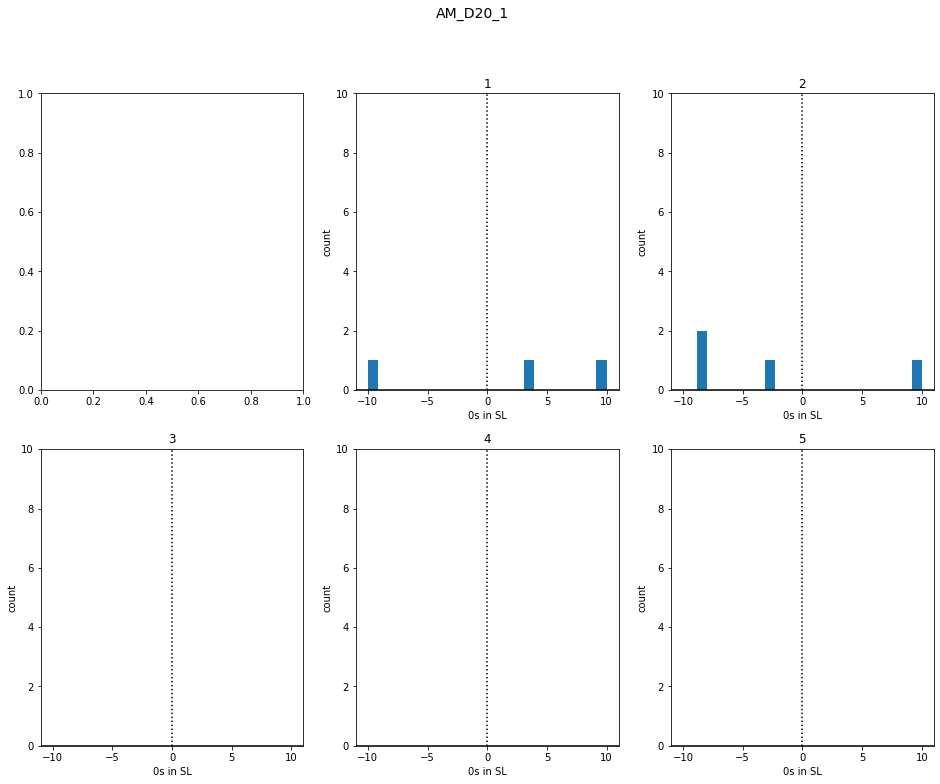

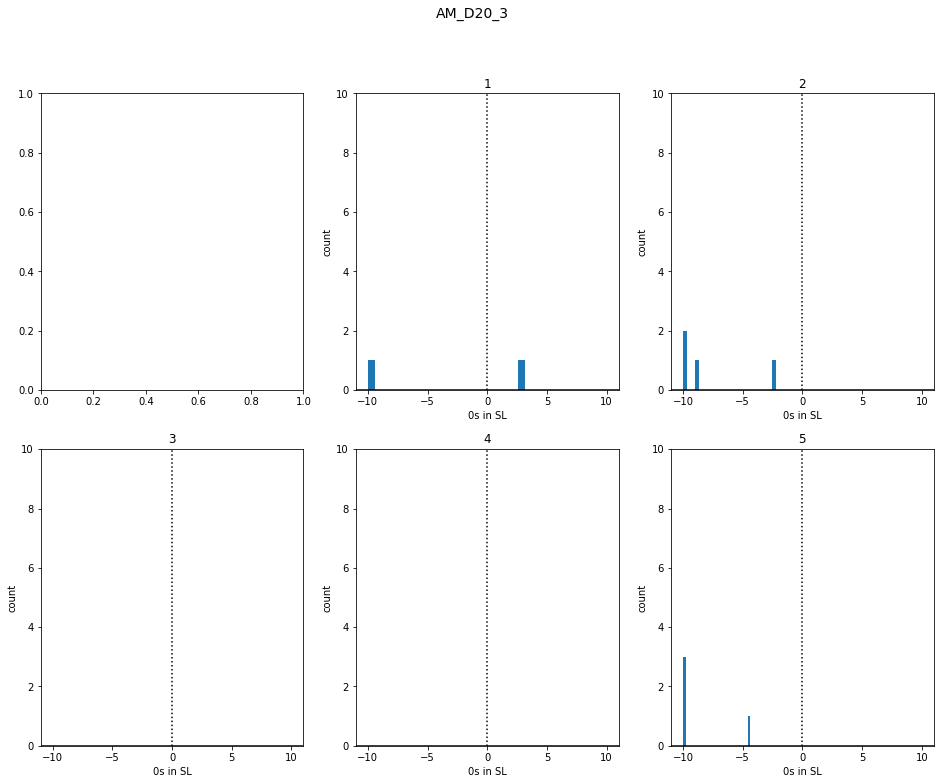

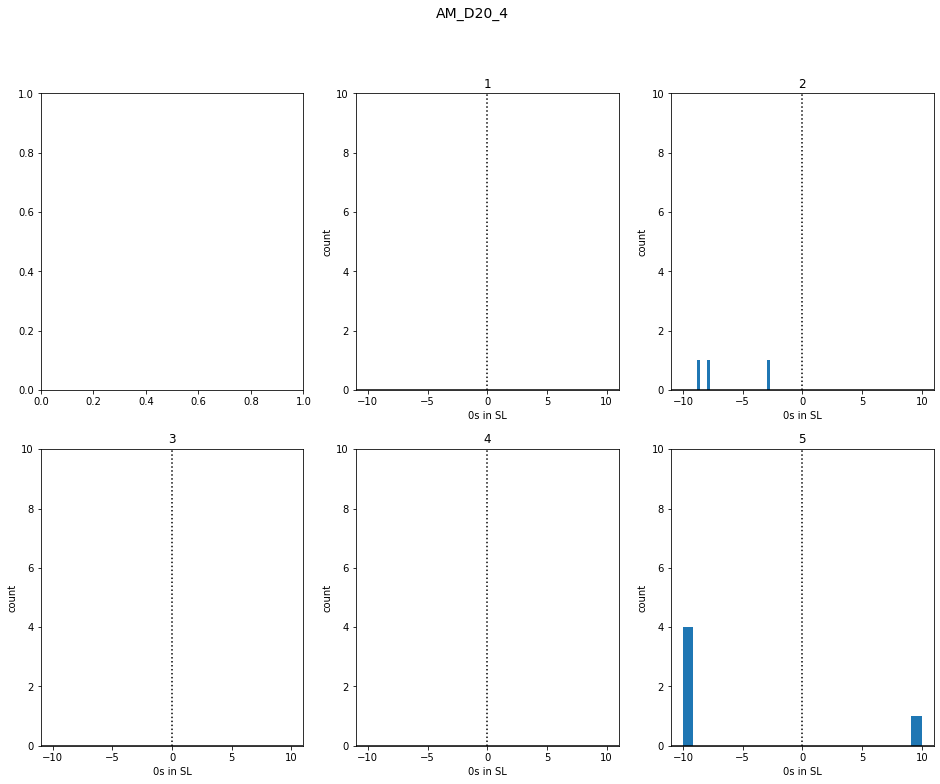

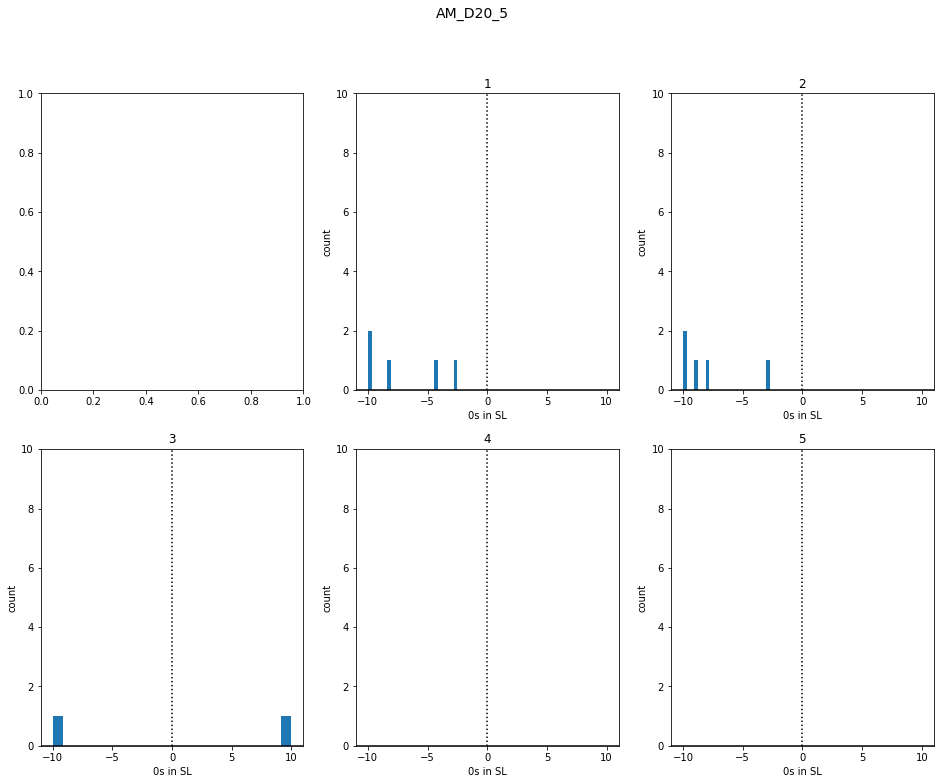

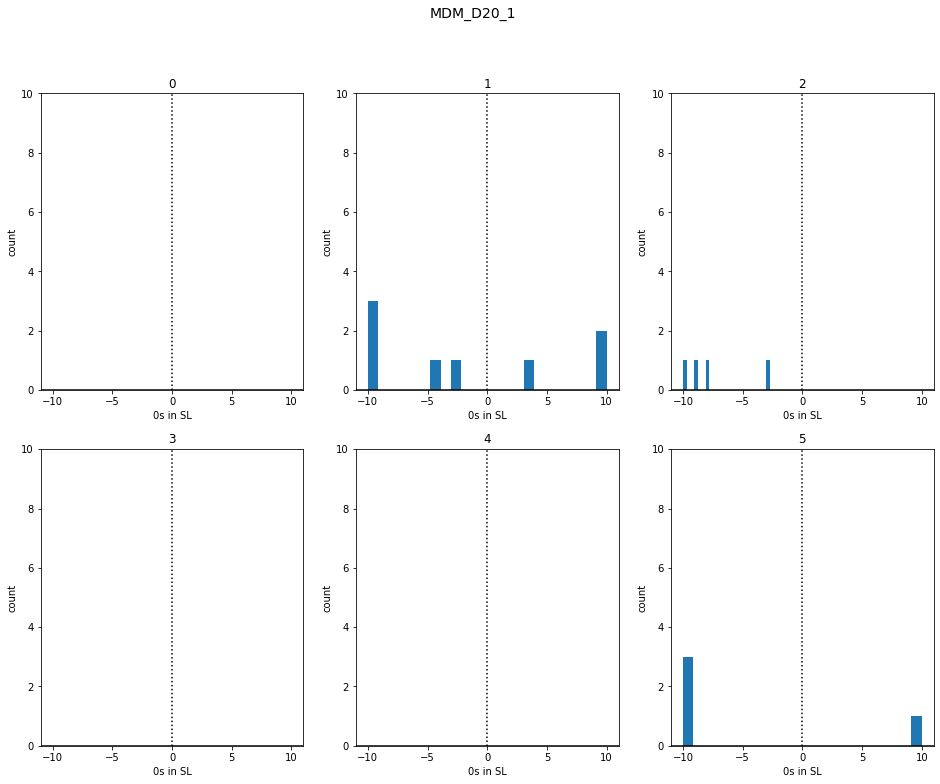

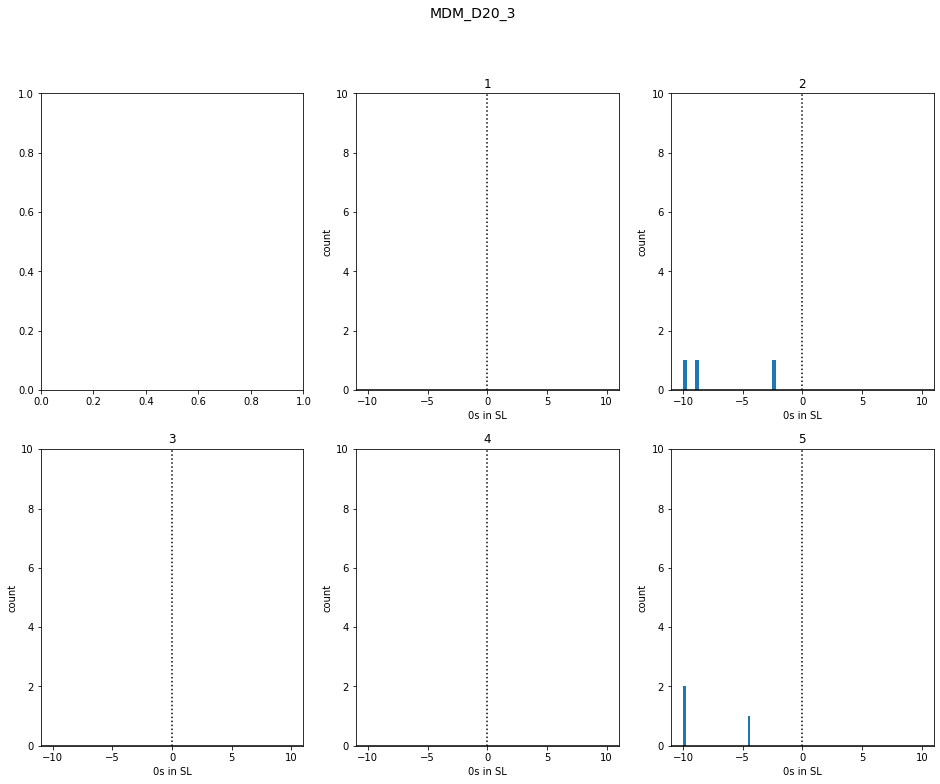

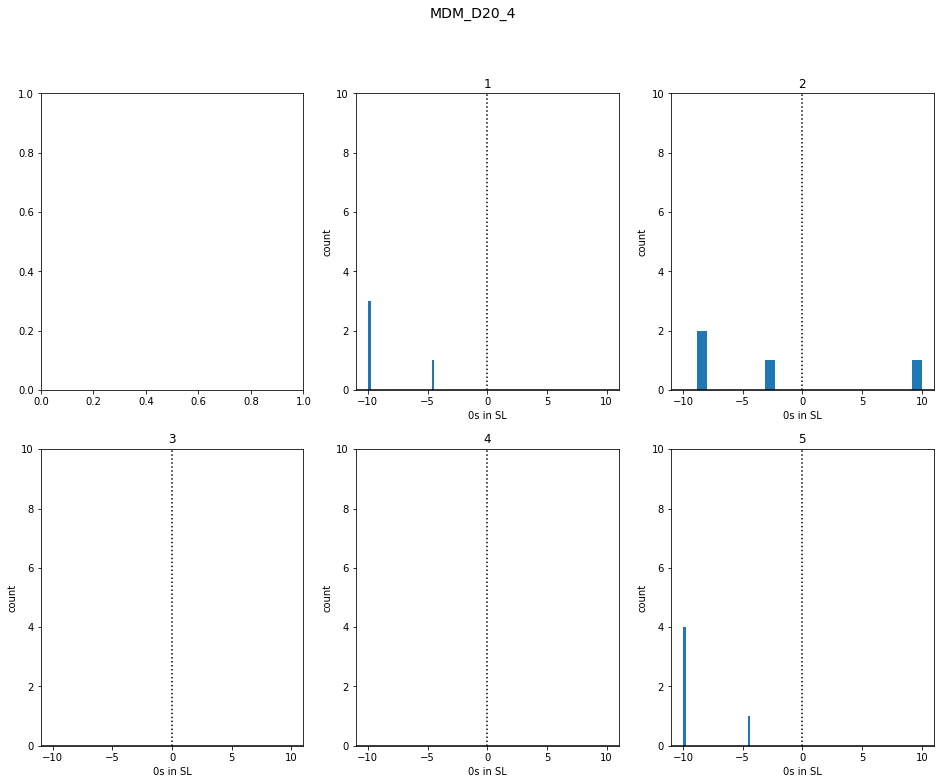

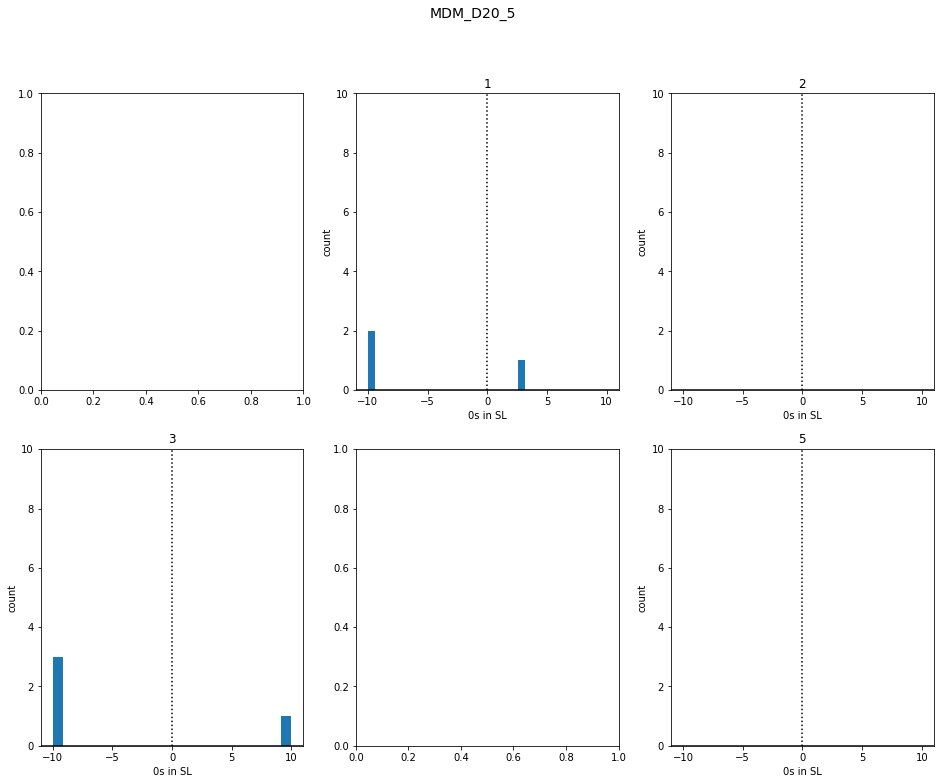

In [15]:
for instance in DF_AM.index:
    ser_X = DF_AM.loc[instance, :]
    histograms(ser_X, title=instance, ylim=[0,10], max_sl=0.01)

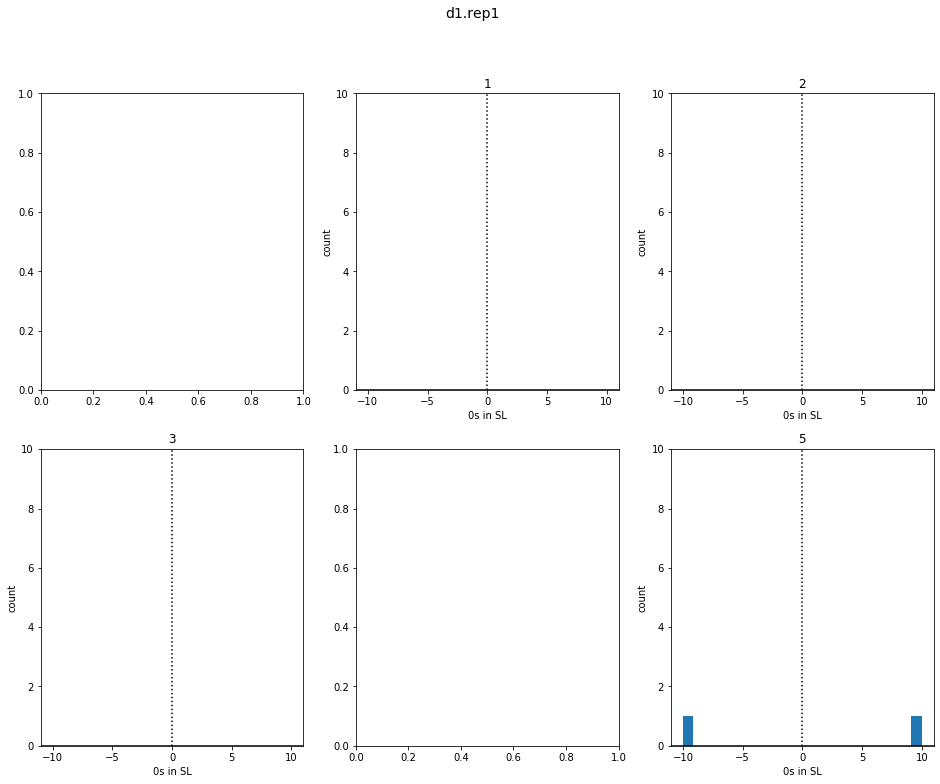

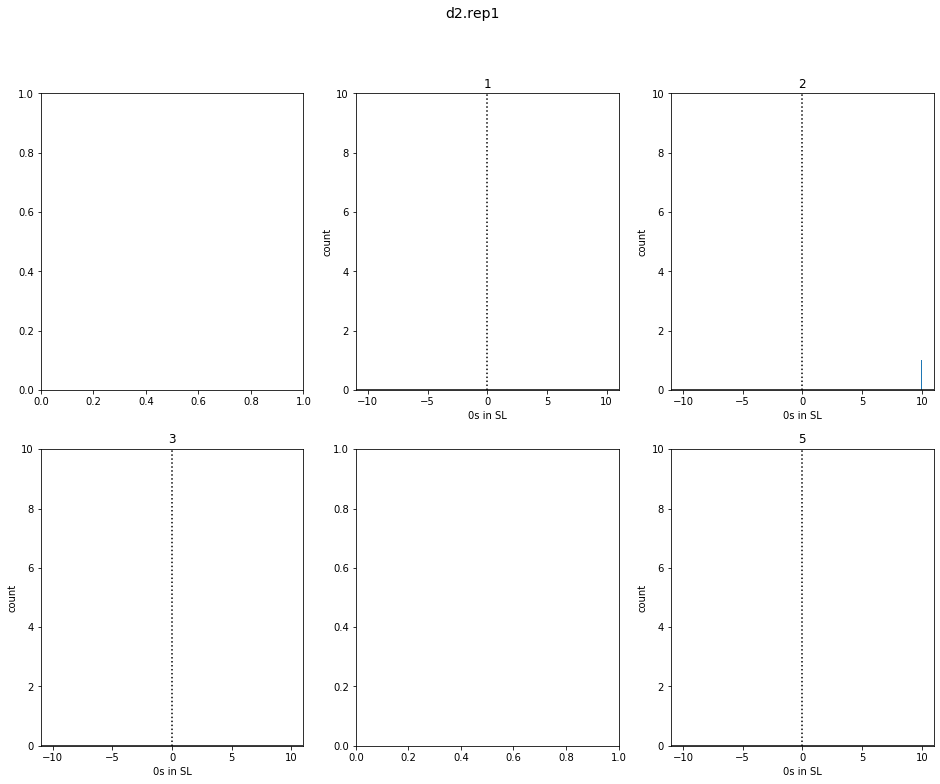

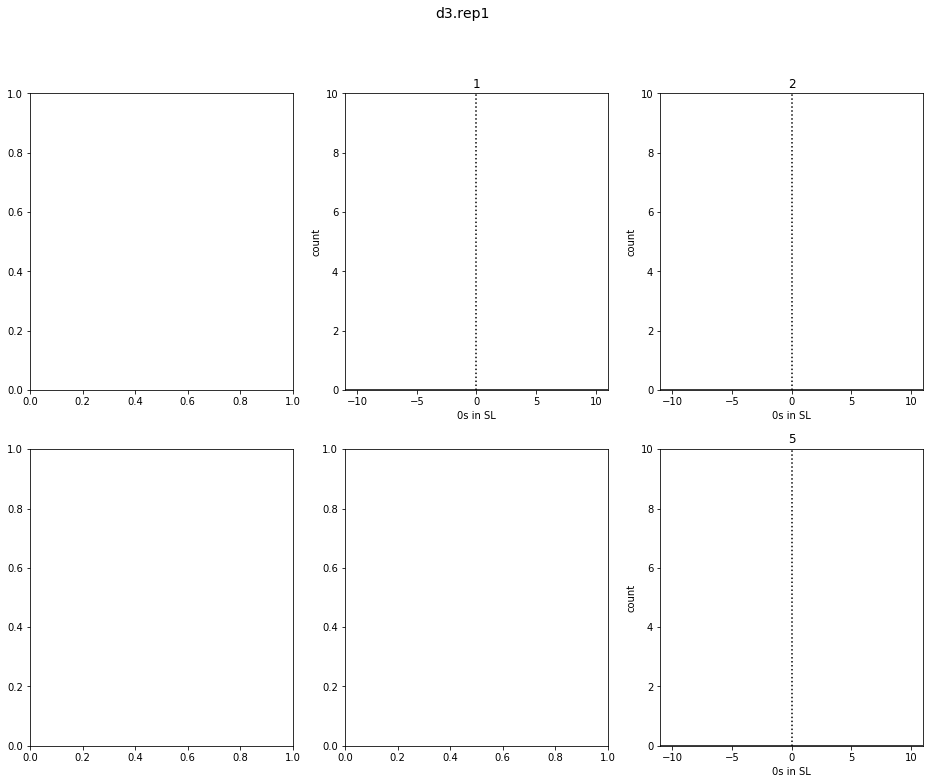

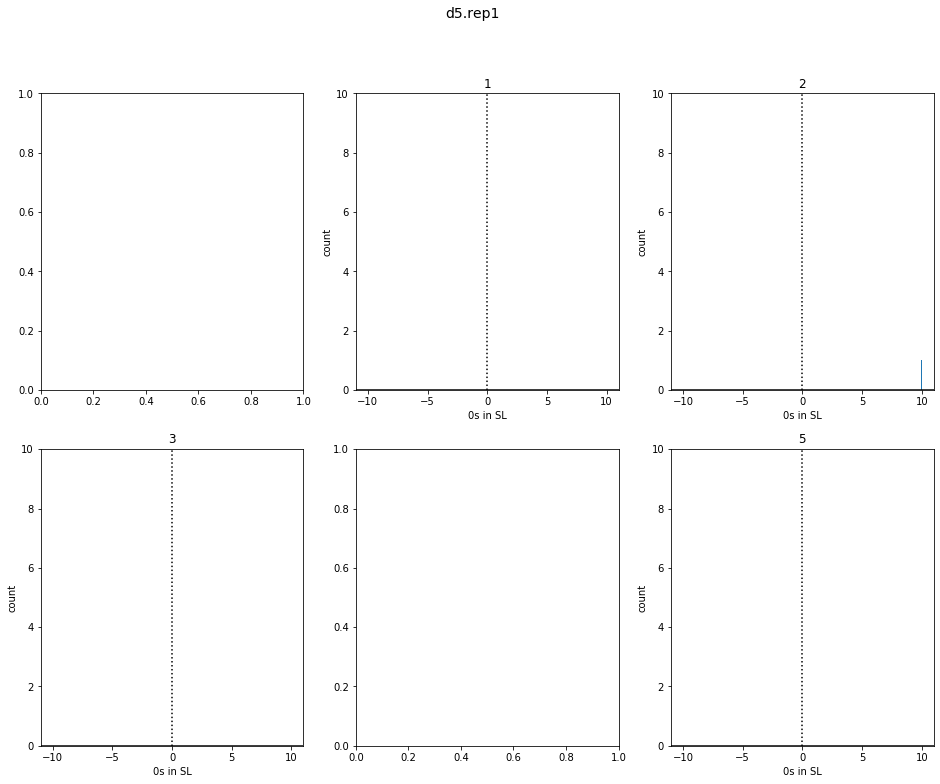

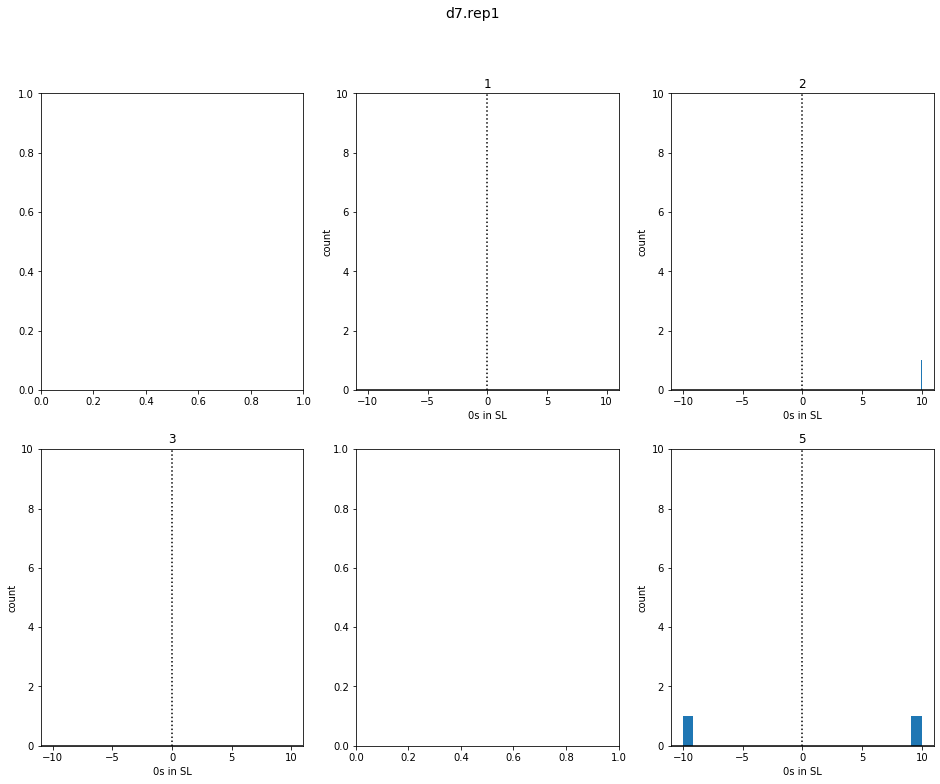

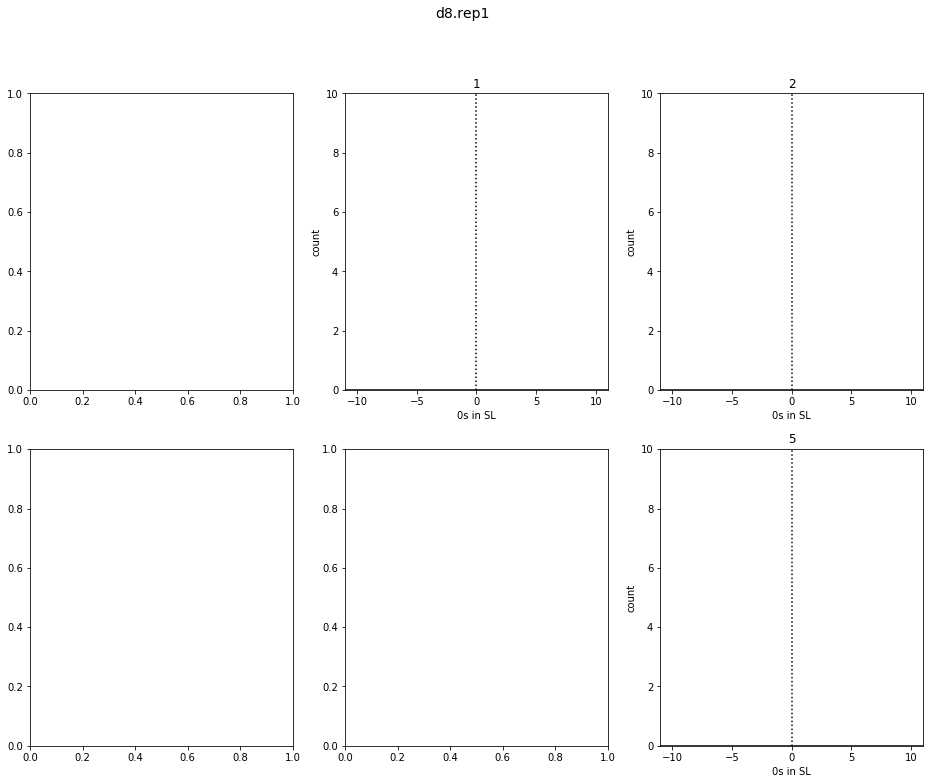

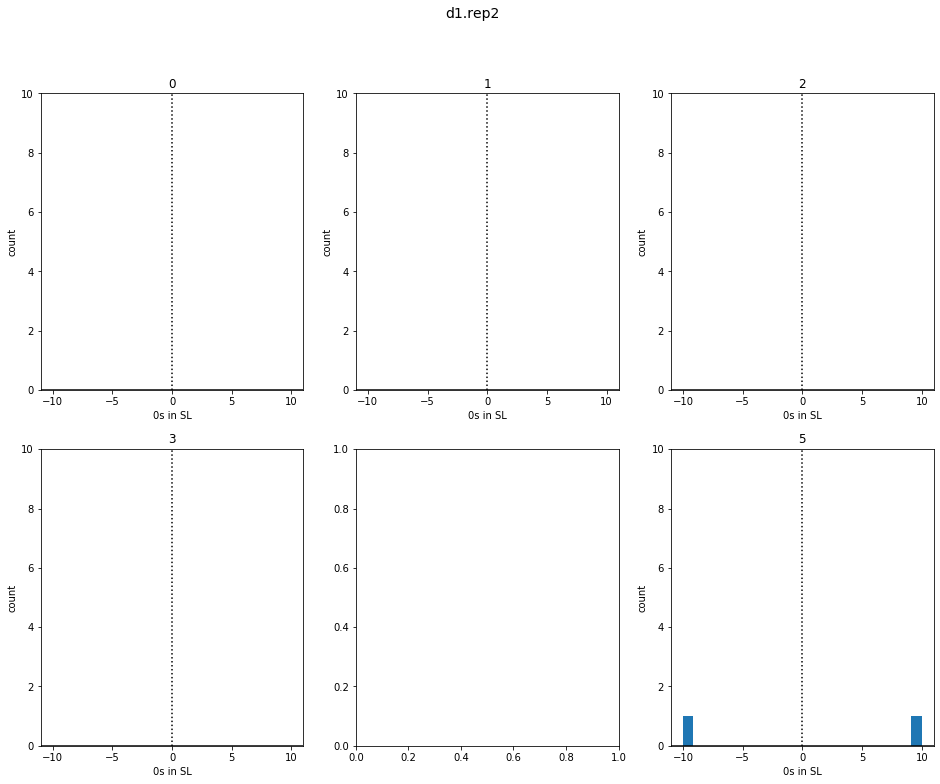

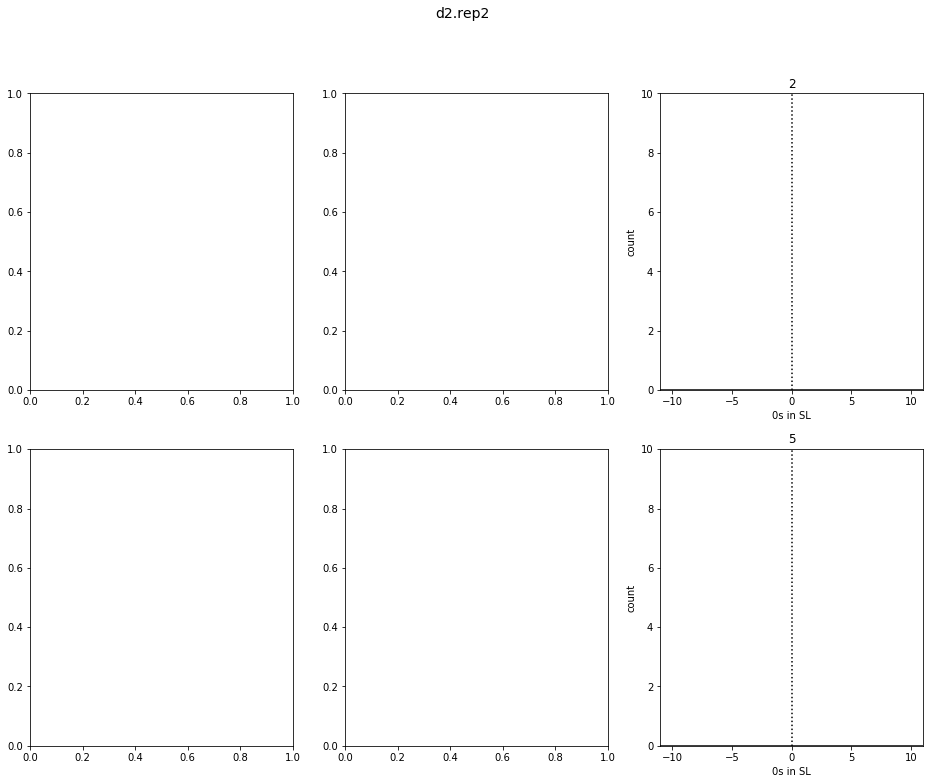

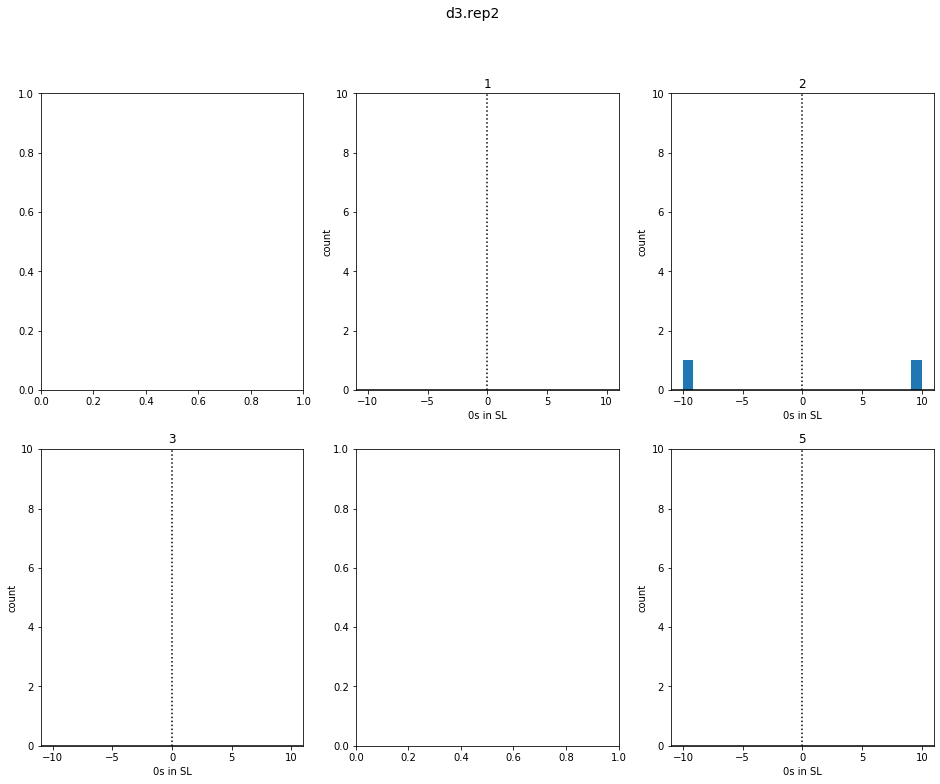

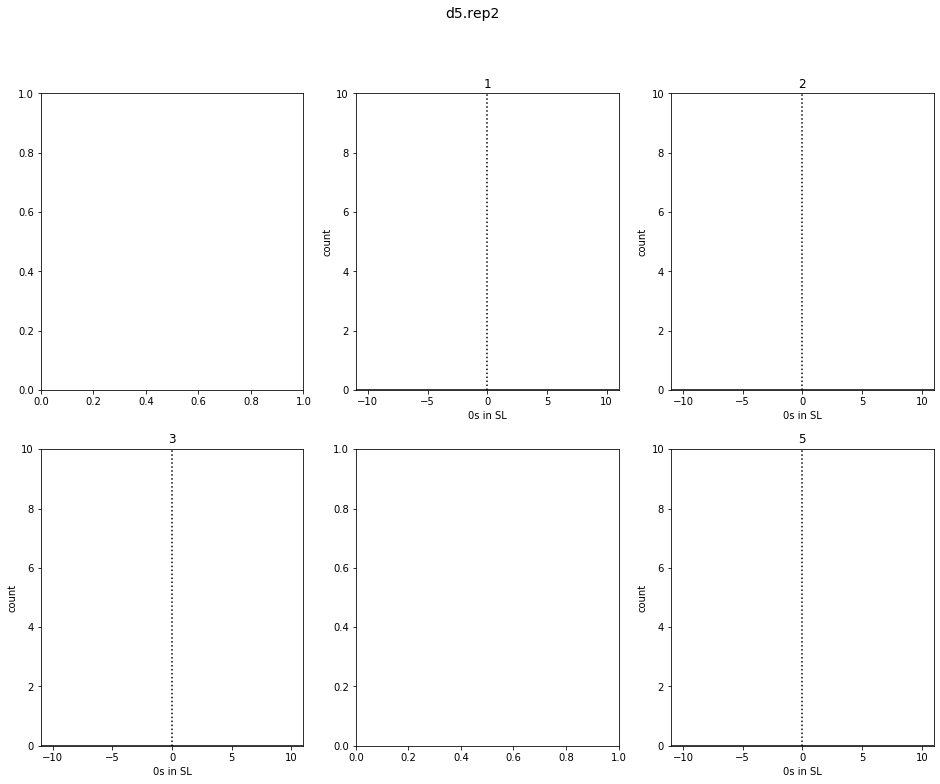

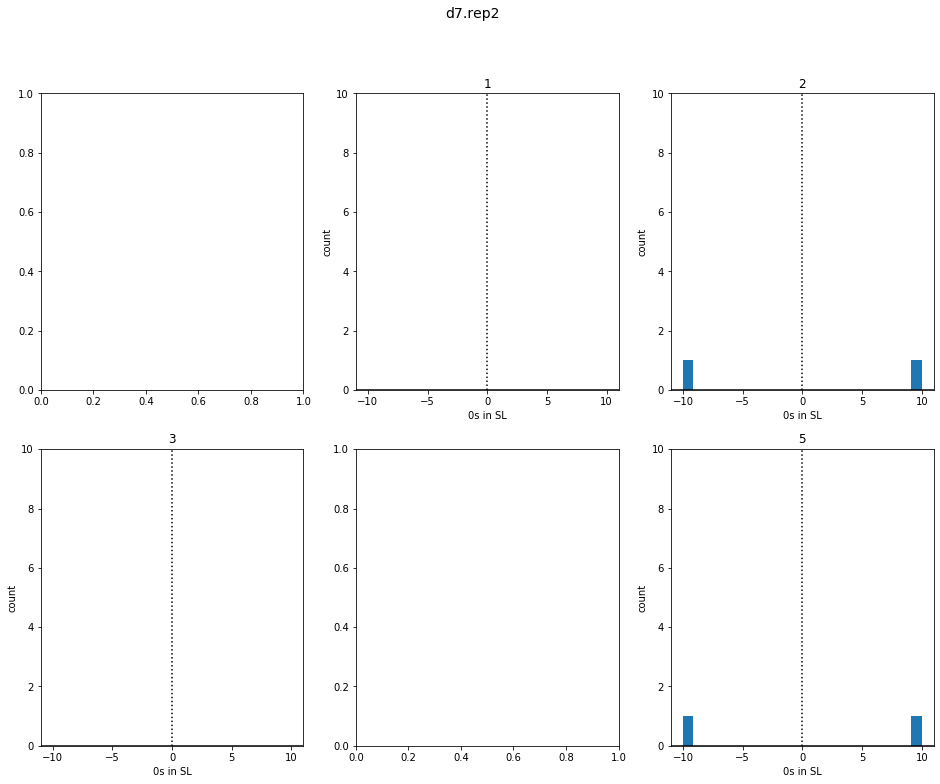

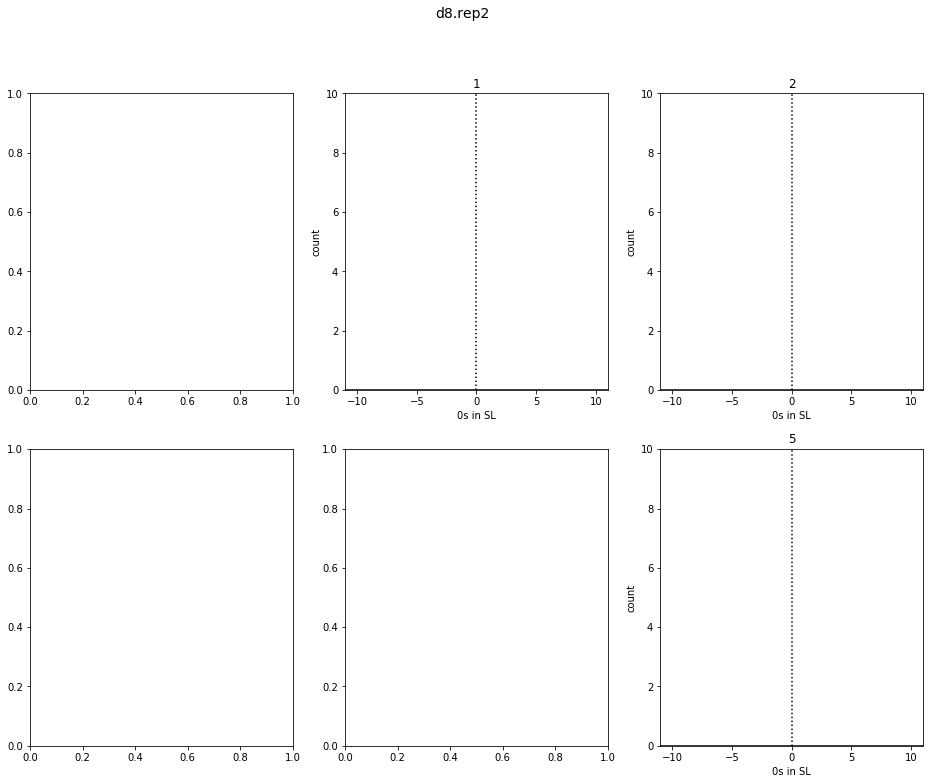

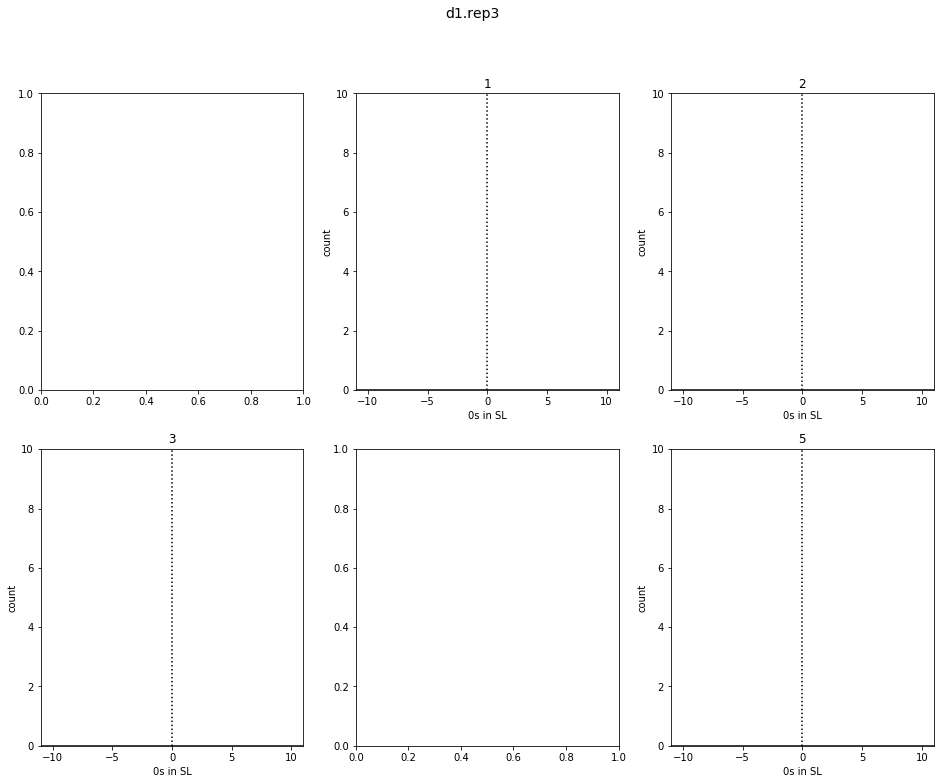

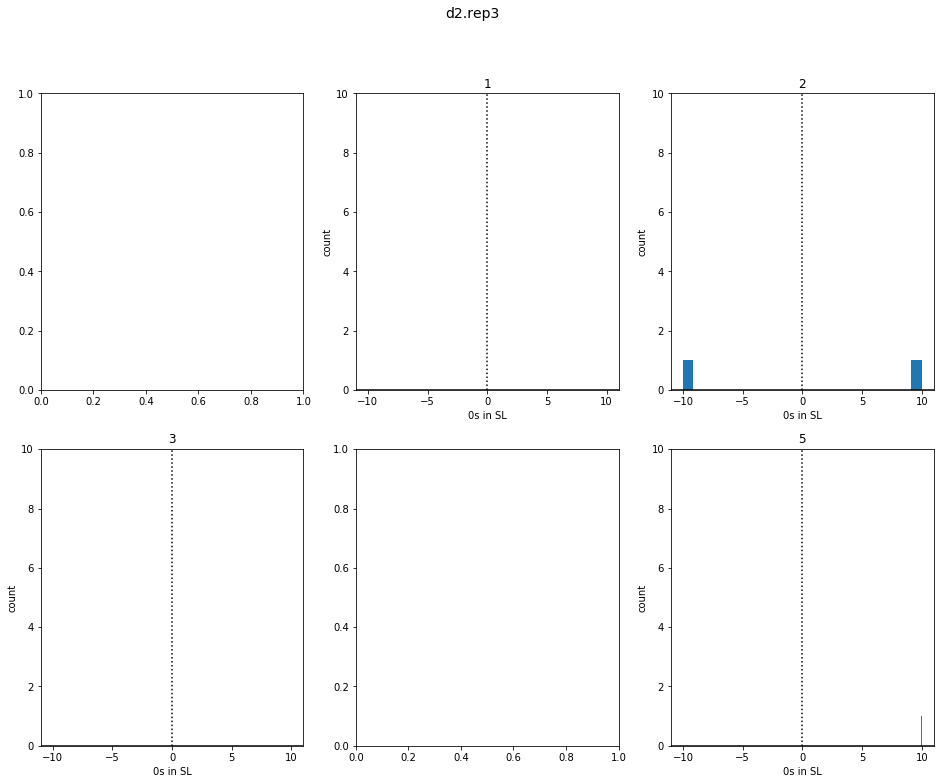

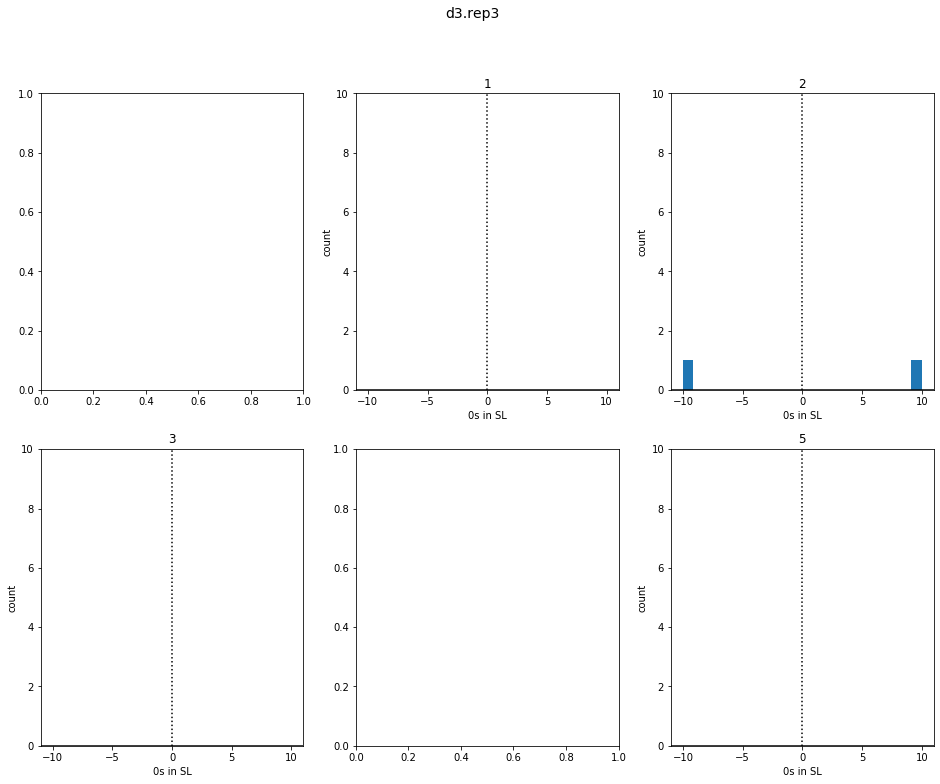

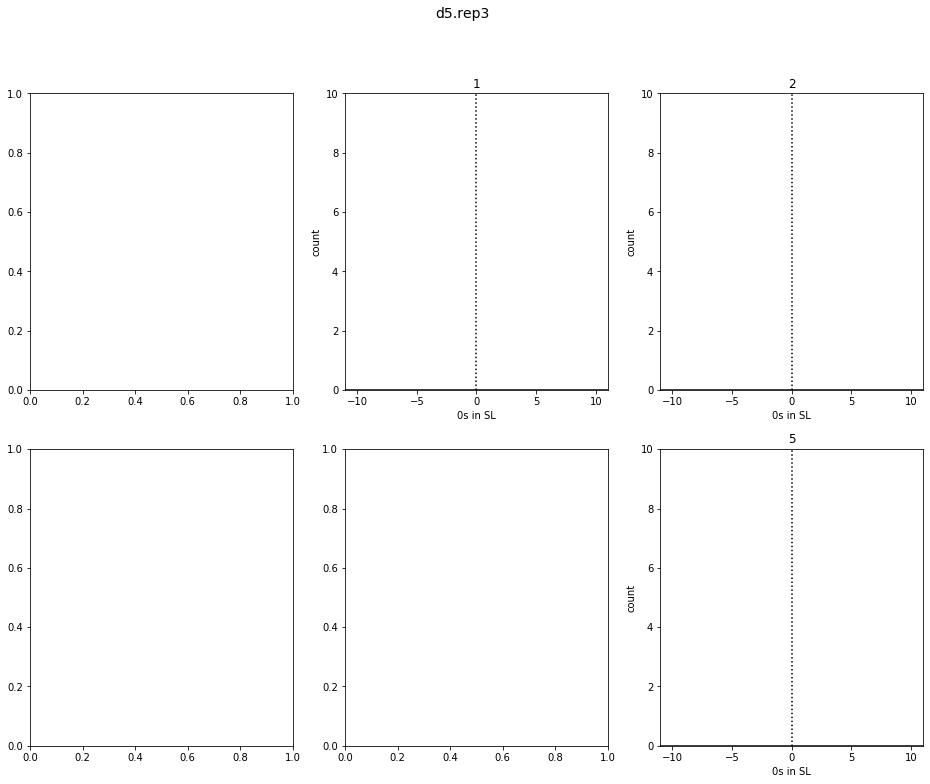

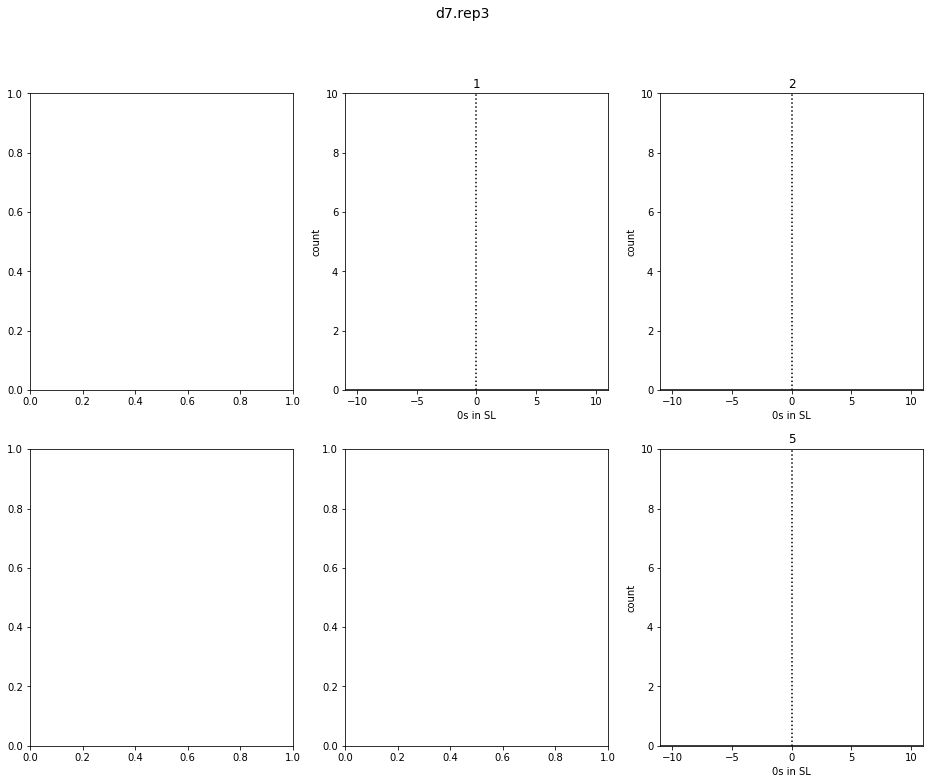

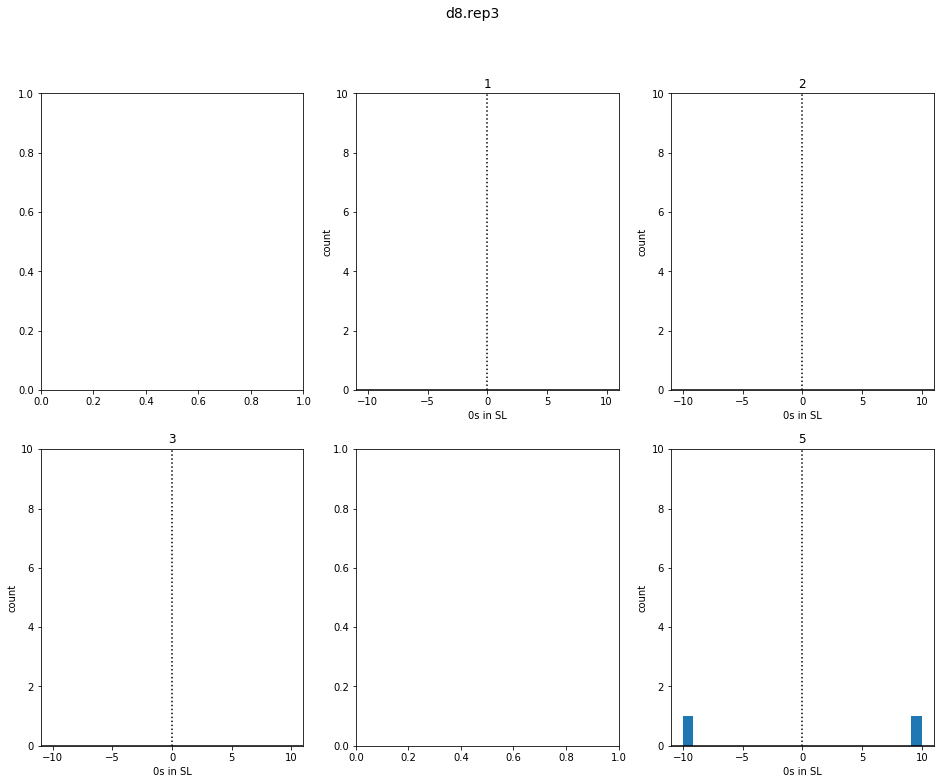

In [16]:
for instance in DF_GALAGAN.index:
    ser_X = DF_GALAGAN.loc[instance, :]
    histograms(ser_X, title=instance, max_sl=0.01, ylim=[0, 10], terms=["hypoxia"])

## Term Analysis
Only include genes that have GO terms hypoxia, lipid, fatty acid.

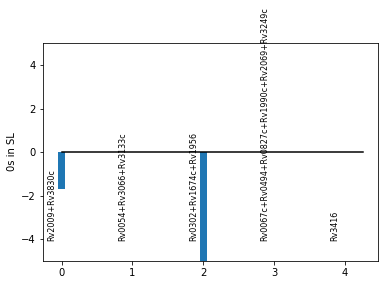

In [13]:
fset_selector = lambda f: util_classifier.countTerms(f, ["hypoxia", "lipid"]) > 0
COLLECTION_DCT[1].plotEvaluate(ser_X, fset_selector=fset_selector, num_fset=100)